#### Import libraries and packages

In [44]:
import psycopg2
import psycopg2.extras as extras
import pandas as pd
import numpy as np
import seaborn as sns

#### Set connection with postgres database

In [45]:
host = 'postgresfib.fib.upc.edu'
dbname = 'ADSDBjordi.cluet'
user = 'jordi.cluet'
pwd = 'DB151199'
port = 6433
sslmode = 'require'

conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, user, pwd))
cursor = conn.cursor()

#### Select whole table as dataframe

In [46]:
sql = "SELECT * from formatted_zone.ajunt_districtes_2021_21_12_24;"
df = pd.read_sql_query(sql, conn)
df.head()

,districte,superficie,poblacio
0,Ciutat Vella,420.5,107858
1,Eixample,746.4,270331
2,Sants-Montjuïc,2288.0,187425
3,Les Corts,601.1,82532
4,Sarrià-Sant Gervasi,1991.6,150888


#### Check data types

In [47]:
df.dtypes

districte      object
superficie    float64
poblacio        int64
dtype: object

#### Correct data types

In [48]:
df['districte'] = df['districte'].astype("category")

In [49]:
df.dtypes

districte     category
superficie     float64
poblacio         int64
dtype: object

#### Quality analysis

In [50]:
df.isna().any().any()

False

Assign a colour to each specific district for the barplots

In [59]:
distr = df.districte.unique()
colours = [ "red", "blue", "green", "yellow", "purple", "orange", "gray", "black", 'brown', 'teal']

zip_iterator = zip(distr, colours) 
palette = dict(zip_iterator)

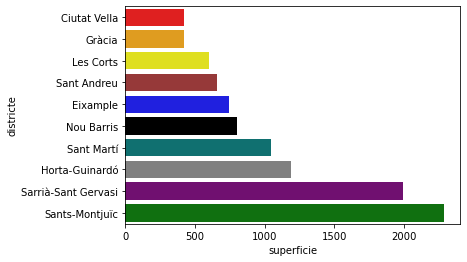

In [61]:
sns.barplot(y='districte', x = 'superficie', data = df, orient= 'h', palette=palette, order=df.groupby(["districte"])["superficie"].max().sort_values().index)

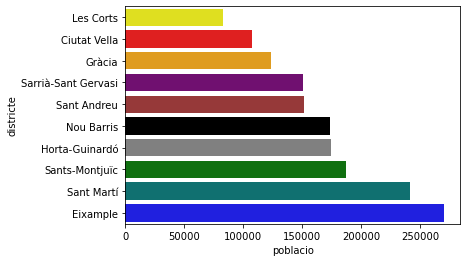

In [62]:
sns.barplot(y='districte', x = 'poblacio', data = df, orient= 'h', palette=palette, order=df.groupby(["districte"])["poblacio"].max().sort_values().index)

### Load districts table into trusted zone

##### Create trusted_zone schema if it does not exist

In [63]:
create_trusted_zone = """CREATE SCHEMA IF NOT EXISTS trusted_zone;"""
cursor.execute(create_trusted_zone)
conn.commit()

##### Create new table in PostgreSQL database

In [64]:
sqlCreateTable = """CREATE TABLE IF NOT EXISTS trusted_zone.ajunt_districtes_2021_21_12_24 (
    DISTRICTE VARCHAR(50), 
    SUPERFICIE FLOAT,
    POBLACIO INTEGER
);"""
cursor.execute(sqlCreateTable)
conn.commit()

##### Insert rows into table

In [65]:
def execute_values(conn, df, table):
  
    tuples = [tuple(x) for x in df.to_numpy()]
  
    cols = ','.join(list(df.columns))
    # SQL query to execute
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("The dataframe was correctly inserted")
    cursor.close()

In [66]:
execute_values(conn, df, 'trusted_zone.ajunt_districtes_2021_21_12_24')

The dataframe was correctly inserted


##### Check correct insertion

In [67]:
sql = "SELECT * from trusted_zone.ajunt_districtes_2021_21_12_24;"
pd.read_sql_query(sql, conn)

,districte,superficie,poblacio
0,Ciutat Vella,420.5,107858
1,Eixample,746.4,270331
2,Sants-Montjuïc,2288.0,187425
3,Les Corts,601.1,82532
4,Sarrià-Sant Gervasi,1991.6,150888
5,Gràcia,422.4,123614
6,Horta-Guinardó,1192.0,174447
7,Nou Barris,805.6,173864
8,Sant Andreu,659.2,151960
9,Sant Martí,1043.7,241263
